# Problema:

$S = \int d^Dx\left(\frac{1}{2}\partial_\mu \Phi(x)\partial_\mu \Phi(x) + \frac{1}{2}m^2 \Phi(x)^2 + \frac{g}{4!} \Phi(x)^4\right)$


In [224]:
# Librerias
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

In [225]:
# Constantes
Nx, Ny = 24, 24    # Numero de puntos de la matriz
Nt = 24   # Numero de puntos de tiempo
h = 1             # cte de Planck
dim = 3

# Variables del metropolis
delta = 2.0       # rango en la accion
sweeps = 5
sweeps_mc = 600

# Espaciado Anisotropico
a_s = 1.0
a_t = 1.0

xi = a_s/a_t
lam = 0.0 # lambda
m = 0.5

k_s = (1-2*lam)/((a_s*m)**2 + 2*xi**2 + 2*dim - 2)
k = xi*k_s

In [226]:
''' ------ Funciones ---- '''

# Para las condiciones periodicas
@nb.njit
def contorno(i,n):
  return i % n

# Neiborhoods
@nb.njit
def N(phi,t,x,y):
  # Condiciones periodicas
  tp = contorno(t+1, Nt); tm = contorno(t-1, Nt)
  xp = contorno(x+1, Nx); xm = contorno(x-1, Nx)
  yp = contorno(y+1, Ny); ym = contorno(y-1, Ny)

  # Vecinos espaciales
  neigh_space = (
        phi[t, xp, y] + phi[t, xm, y] +
        phi[t, x, yp] + phi[t, x, ym]
  )
  # Vecinos temporales
  neigh_time = (
      phi[tp, x, y] + phi[tm, x, y]
  )

  # Funcion de los vecinos
  return -(2*k)/xi * neigh_space - 2*k*xi * neigh_time

@nb.njit
def cambio_accion(phi,t, x, y, d, lam):
  #Parametros para el cambio en la accion
  a0 = N(phi,t,x,y) + 2*phi[t,x,y]*(1 + 2*lam*(phi[t,x,y]**2 - 1))
  a1 = 1 + 2*lam*(3*phi[t,x,y]**2 - 1)
  a2 = 4*lam*phi[t,x,y]
  a3 = lam

  # Cálculo del cambio en la acción (ΔS)
  return d*(a0 + a1*d + a2*d**2 + a3*d**3)

@nb.njit
# Barrido de metropolis
def metropolis(phi, lam, delta):
  aceptados = 0
  Nt, Nx ,Ny = phi.shape
  N = Nt * Nx * Ny

  # Eleccion de indices de forma aleatoria
  indices = np.arange(N)
  np.random.shuffle(indices)

  for idx in indices:
    # Convertir a (t, x, y)
    t = idx // (Nx * Ny)
    x = (idx // Ny) % Nx
    y = idx % Ny

    phi_antiguo = phi[t,x,y]
    d = np.random.uniform(-delta, delta)
    phi_nuevo = phi_antiguo + d

    dS = cambio_accion(phi,t,x,y,d,lam)

    # Condición de Metropolis
    if dS < 0 or np.random.rand() < np.exp(-dS / h):
        phi[t,x,y] = phi_nuevo
        aceptados += 1

  return phi, aceptados / N  # Tasa de aceptación

In [227]:
@nb.njit
def metropolis_seq(phi, lam, delta):
    aceptados = 0
    Nt, Nx, Ny = phi.shape
    N = Nt * Nx * Ny

    for t in range(Nt):
        for x in range(Nx):
            for y in range(Ny):
                phi_antiguo = phi[t, x, y]
                d = np.random.uniform(-delta, delta)
                phi_nuevo = phi_antiguo + d

                dS = cambio_accion(phi, t, x, y, d, lam)

                # Condición de Metropolis
                if dS < 0 or np.random.rand() < np.exp(-dS / h):
                    phi[t, x, y] = phi_nuevo
                    aceptados += 1

    return phi, aceptados / N  # tasa de aceptación


In [228]:
# -------------------- Inicializacion --------------------
phi = np.random.normal(scale=0.1, size=(Nt,Nx,Ny))

configs = []
n_mediciones = []
tasas_aceptacion = []

# -------------------- Simulación --------------------
for _ in range(sweeps_mc):
  for sweep in range(sweeps):
    phi, acept = metropolis(phi, lam, delta)
    tasas_aceptacion.append(acept)

    # Guardar configuración cada n_steps sweeps
    #if sweep % n_steps == 0 and sweep >= n_thermal:
    configs.append(np.array(np.mean(phi)))

# n_thermal es el numero de sweeps que descartamos para termalizar el sistema

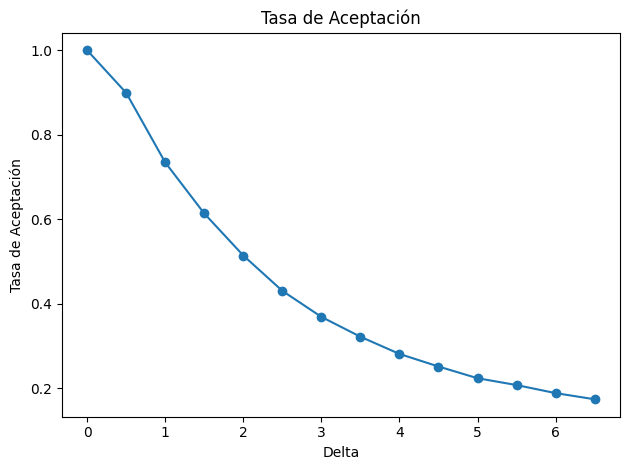

In [229]:
# 1 simulacion completa por cada valor de delta
phi = np.random.normal(scale=0.1, size=(Nt,Nx,Ny))
delta_range = np.arange(0,7,0.5)
tasas_aceptacion = []

# Simulación
for delta in delta_range:
    acept_sum = 0.0
    for _ in range(sweeps):
        phi, acept = metropolis(phi, lam, delta)
        acept_sum += acept

    tasas_aceptacion.append(acept_sum / sweeps)

plt.plot(delta_range, tasas_aceptacion, marker='o', linestyle='-')
plt.xlabel("Delta")
plt.ylabel("Tasa de Aceptación")
plt.title("Tasa de Aceptación")

plt.tight_layout()
plt.show()

# Autocorrelacion


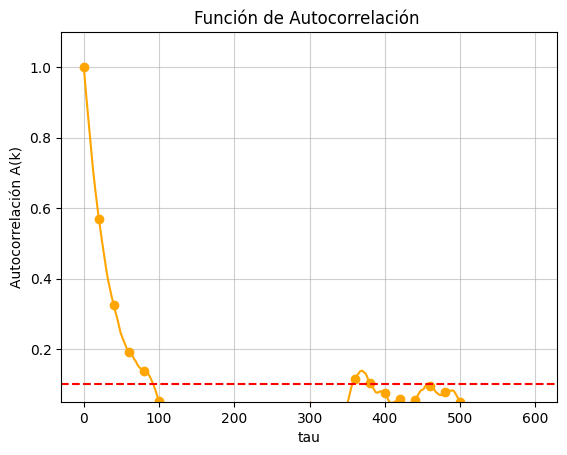

In [230]:
def autocorrelation(config,desfase,t_max):
  z = config.shape[0]
  phi_mean = np.mean(config)
  phi_var = np.var(config)

  autocorrelation_function = []
  t_range = np.arange(0,t_max,desfase)

  for i in t_range:
      # Calcular A(k)
      # Tomar dos "rodajas" del array, separadas por k
      data_t = config[0 : z-i]
      data_t_plus_k = config[i : z]

      # Calcular el producto de las fluctuaciones
      covariance_k = np.mean( (data_t - phi_mean) * (data_t_plus_k - phi_mean) )

      # Normalizar por la varianza
      A_k = covariance_k / phi_var
      autocorrelation_function.append(A_k)

  return t_range[:len(autocorrelation_function)], autocorrelation_function

configs = np.array([configs])
datos_corregidos = np.squeeze(configs)
t = int(1/(2*a_s*m))

x = np.arange(0, sweeps_mc,t)
k_lags, a = autocorrelation(datos_corregidos, t, sweeps_mc)

plt.plot(k_lags, a,marker='o',markevery=20, color='orange')
plt.axhline(0.1, color='red', linestyle='--')
plt.xlabel("tau")
plt.ylabel("Autocorrelación A(k)")
plt.title("Función de Autocorrelación ")
plt.grid(True, alpha=0.6)
plt.ylim(0.05,1.1)
plt.savefig("m01", dpi=400, bbox_inches='tight')
plt.show()